In [383]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [384]:
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt
import random
from IPython import display
import math

## Utility Code from my_utils.py

In [385]:
# from my_utils.py from the labs
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [386]:
# from my_utils.py from the labs
# simple lambda functions to help get training metrics
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)

In [387]:
# from my_utils.py from the labs
# Defined in file: ./chapter_preliminaries/calculus.md
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [388]:
# from my_utils.py from the labs
# Defined in file: ./chapter_preliminaries/calculus.md
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

In [389]:
# adapted to add text to plot from my_utils.py from the labs
# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(7, 7), caption=None):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        self.fig.subplots_adjust(bottom=0.37)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
        self.loss_label = None
        self.caption = caption

    def add(self, x, y, data_label=None, caption=None):
        data_label_point_x, data_label_point_y = x, y
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        if data_label:
          self.fig.suptitle(data_label)
        if self.caption:
          self.fig.text(0.15, 0.00, self.caption, wrap=True, horizontalalignment='left', fontsize=8, linespacing=1.5)
        
        display.display(self.fig)
        display.clear_output(wait=True)

# ECS269U/P - Coursework


* The **goal** of the CW is similar to that of Week 2's Lab: fitting a curve to data, also known as **curve fitting**. 
* This has applications in many different disciplines that make use of AI: FinTech, Physics Modelling, or even Sports. 
* For example, we might be interested in learning the evolution (over time) of the price of a specific product in different countries. This can depend on several factors: the product itself, the country, the initial value of the product's price, etc. 
* As usual, we are interested in learning a model that finds these relationships *from the data*. 


## Learning a family of functions

* The main difference with Week 2's Lab is that we will learn a network that does not learn a single function but a *family of functions*.
* We will consider a family of sinusoidal functions. 
* Below you can find the code generating the data according to different random sinusoidal functions $\{f_a\}$. We randomly generate a set of 40 points in the x-axis in the interval $[-2, 2]$, slightly randomly shifted. Our functions will have the form of $y = f_a(x) = a * sin(x+a)$ where each $a$ will be randomly sampled for each function from interval $[-2, 2]$.  To "draw" a function $f_a$, we first choose some $a \sim U(-2,2)$ and then we compute $f_a$ using the above formula for all the $x$ in the x-axis. 


In [390]:
Nf = 2000 # the number of different functions f that we will generate
Npts = 40 # the number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1)
for k in range(Nf):
    x[k,:,0] = torch.linspace(-2, 2, Npts)

x += torch.rand_like(x)*0.1
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a)

## The Learning Goal

* Because we are dealing with a family of functions and not just a single function, our model must be able to perform two tasks: *Function Selection* and *Regression*.
* Function selection means that given some *additional* input (to be defined below) the model somehow must choose which function $f_a$ from the family of functions $\{f_a\}$ it needs to model.
* Once the correct function is picked then the model must perform regression i.e. learn the relationship $y=f_a(x)$.




## The Learning Objective

* During training we randomly sample functions from the family of functions $\{f_a\}$. For each $f_a$, we are provided with the (input, output) pairs $(x_t, y_t), t=1,\dots,N_{pts}$.

* To perform *Function Selection*, a **random subset** of $(x_t, y_t), t=1,\dots,N_{pts}$ is provided as auxiliary input to the model during *both training and testing*. These auxiliary data is called the *context data:* $(x_c, y_c), c=1,\dots,N_c$. 

* Note that the total number of context points $N_c$ should be different (and randomly chosen) for every batch so that the model learns to handle different number of context points at test time. This means that the model should be able to work for e.g. $N_c=5$ but also for $N_c=12$ etc.

* Our model will take the context pairs $(x_c, y_c)$ and input values $x_t$ and will produce the estimated values $\hat{y}_t$. 

* During training we have access to the ground-truth values $y_t$, and thus we can compute a loss between the model's predictions $\hat{y}_t$ and the ground-truth values $y_t$.  


## The Model

* Our model will consists of 2 MLPs which must be jointly trained.
* The first MLP is called the *Context Encoder* or Encoder. The Encoder will take as input each pair $(x_c, y_c)$ and will produce a corresponding feature representation $r_c$ of dimension $r_{dim}$.
* A total context feature is produced by averaging over all features: $r_C= \frac{1}{N}\sum_c r_c$.
* The second MLP is called the Decoder. It takes as input the $r_C$ and each input data $x_t$ and produces the model's prediction $\hat{y}_t$. 



![Encoder-Decoder](https://drive.google.com/uc?export=view&id=1Yjagy_Bn0jpWX0P3gis7RFXZTe7a_aW0)


## Architectures

* The Encoder and the Decoder are **MLPs**. You can experiment with your own architectures. You can also choose to implement the following architectures:
    * *Encoder*: It will map the input pair 
$(x_c, y_c)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the feature representation $r_c$ of dimension $r_{dim}$.
    * *Decoder*: It will map the input pair $(r_C, x_t)$ to some features of dimension $h_{dim}$ using 2 *hidden* layers. A final layer will produce the model's prediction $\hat{y}_t$.

## Tasks

* You have to implement the following:
    1. Create the training dataset and dataloader (10%). 
    2. Create the Encoder and Decoder (20 + 20%). 
    3. Create the optimizer and the loss for your model (10%).
    4. Write the training script that will train the model and print the training loss (30%).
    5. Evaluate the model on some validation data. Plot some predictions. (10%). 

* You might want to explore the impact of the following design choices and hyperparameters:
    1. Number of hidden layers and 
$h_{dim}$, and  $r_{dim}$.
    1. Type of optimizer, batch-size and all relevant hyper-parameters from Week 5.

# Task 1 - Training dataset and dataloader (10%)


In [391]:
# dataset

class Dataset(torch.utils.data.Dataset):
  def __init__(self, Nf=2000, Npts=40):
    'Initialization'
    self.Nf = Nf # the number of different functions f that we will generate
    self.Npts = Npts # the number of x values that we will use to generate each fa

    x, y = self.__generate_functions__()
    self.x_values = x
    self.y_values = y

  def __len__(self):
    'Denotes the total number of samples'
    return len(self.y_values)
  
  def __getitem__(self, index):
    'Generates one sample of data'
    # Select sample
    X = self.x_values[index]
    Y = self.y_values[index]
    return X, Y
  
  def __generate_functions__(self):
    # provided coursework code
    x = torch.zeros(self.Nf, self.Npts, 1) # (function, x values, 1)
    for k in range(Nf):
        x[k,:,0] = torch.linspace(-2, 2, Npts)

    x += torch.rand_like(x)*0.1
    a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
    y = a*torch.sin(x+a)

    return x, y

In [392]:
#@title Data Set/Loader Parameters { display-mode: "both" }

# number of functions to generate
Nf = 2000 #@param {type:"integer"}

# number of x,y values to generate per function
Npts = 40 #@param {type:"integer"}

# initialise the dataset, generating the functions using Nf and Npts params
ds = Dataset(Nf, Npts)

# percentage of data to be training/test data
training_test_data_split = 0.8 #@param {type:"slider", min:0, max:1, step:0.1}

# train:test 80:20 split
train_size = int(training_test_data_split * len(ds))
test_size = len(ds) - train_size
train_data, test_data = torch.utils.data.random_split(ds, [train_size, test_size])

batch_size =  16#@param {type:"integer"}

# data iterators ready for training and testing
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data, 1, shuffle=True)

# Task 2 - Encoder and Decoder (20 + 20%)



In [393]:
#@title Network Parameters { display-mode: "both" }
h_dim =  256#@param {type:"integer"}
r_dim =  1#@param {type:"integer"}
num_inputs =  2#@param {type:"integer"}
decoder_outputs =  1#@param {type:"integer"}

class Net(nn.Module):
  def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.ReLU1 = nn.ReLU()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.linear2 = nn.Linear(num_hidden, num_outputs)

  def forward(self, x):
    layer_1_out = self.linear1(x)
    layer_1_relu_out = self.ReLU1(layer_1_out)
    out = self.linear2(layer_1_relu_out)
    return out

encoder = Net(num_inputs, h_dim, r_dim)
decoder = Net(num_inputs, h_dim, decoder_outputs)

# initialise weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=0.01)
        nn.init.zeros_(m.bias)

encoder.apply(init_weights)
decoder.apply(init_weights)

Net(
  (ReLU1): ReLU()
  (linear1): Linear(in_features=2, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)

# 3. Optimizer and the loss for the model (10%)

In [394]:
#@title Optimiser and Loss Parameters { display-mode: "both" }
learning_rate = 0.005 #@param {type:"number"}
weight_decay = 0.0005 #@param {type:"number"}

# use MSE as it is generally prefered for regression problems
loss = nn.MSELoss()

# use Adam for better results
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate, weight_decay=weight_decay)

# 4. Training script that will train the model and print the training loss (30%)

In [395]:
def train_epoch_ch3(encoder, decoder, train_iter, loss, optimizer):
    """The training function for one epoch."""

    # set the models to train mode
    encoder.train()
    decoder.train()

    # Sum of training loss, no. of examples
    metric = Accumulator(2)

    for xt, yt in train_iter:

        # clear gradients for every parameter in each model
        optimizer.zero_grad()
        
        # combine x and y into one tensor with 2 feature dimentions
        xt_yt = torch.cat((xt, yt), dim=2) 

        # take only a random Nc number of x_y points (subset) to get xc and yc
        Nc = random.randint(1, Npts)
        rand_columns = torch.randperm(Npts)[:Nc]
        xc_yc = xt_yt[:, rand_columns]
        
        # pass context points to encoder to get r_c of r_dim dimention
        r_c = encoder(xc_yc)

        # get mean of all but first dim (i.e 2nd and 3rd dimentions) 
        # aka single mean value for each batch
        # i.e. r_c.size() == (batch_size, Nc, r_dim)
        #      r_C.size() == (batch_size, 1, 1)
        r_C = r_c.view(r_c.size(0), -1).mean(1).view(-1, 1, 1)

        # alternative imperative approach to get mean of 2nd and 3rd dim
        # r_C = torch.mean(r_c, (1,2), True)
       
        # 1. Expand the mean value tensor to match the size of xt
        #    i.e. r_C: (batch_size, 1, 1)-> xt: (batch_size, Npts, 1)
        # 2. Then concatenate them along the 3rd dimention 
        #    i.e. r_C: (batch_size, Npts, 1) + xt:(batch_size, Npts, 1) 
        #     = (batch_size, Npts, 2)
        rc_xt = torch.cat((r_C.expand_as(xt), xt), dim=2)

        # get prediction of yt from model
        y_hat = decoder(rc_xt)

        # calc loss
        l = loss(y_hat, yt)

        # compute change in loss with respect to each paramter with 
        # requires_grad = True
        l.backward()

        # update the model weights
        optimizer.step()

        # collect loss metrics
        metric.add(reduce_sum(l), size(l))

    # Return training loss
    return metric[0] / metric[1]

def train_ch3(encoder, decoder, train_iter, test_iter, loss, num_epochs, 
              optimizer, animation=False):
    """Train a model."""
    if animation:
        animator = Animator(xlabel='epoch', ylabel='train loss',
                        xlim=[1, num_epochs], ylim=[0.0, 0.4],
                        figsize=(7,7))
    for epoch in range(num_epochs):
        train_loss = train_epoch_ch3(encoder, decoder, 
                                     train_iter, loss, optimizer)
        if animation:
          animator.add(epoch + 1, train_loss, 
                       data_label="epoch {}\nloss: {}".format(epoch + 1, round(train_loss,3)))
        else:
          print("epoch:", epoch + 1, "loss", train_loss)
    
    # print hyperparams at end
    caption = "batch_size: {}, loss_function: {}, optimizer: {}, learning_rate: {}\nweight_decay: {}, h_dim: {}, r_dim: {}\n\nencoder: {}\n\ndecoder: {}".format(
        batch_size, loss, optimizer.__class__.__name__, learning_rate, weight_decay, h_dim, r_dim, encoder, decoder
    )
    print(caption)


batch_size: 16, loss_function: MSELoss(), optimizer: Adam, learning_rate: 0.005
weight_decay: 0.0005, h_dim: 256, r_dim: 1

encoder: Net(
  (ReLU1): ReLU()
  (linear1): Linear(in_features=2, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)

decoder: Net(
  (ReLU1): ReLU()
  (linear1): Linear(in_features=2, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)


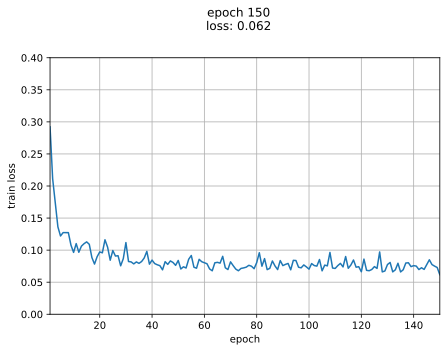

In [396]:
#@title Training Parameters { display-mode: "both" }
num_epochs =  150#@param {type:"integer"}
#@markdown If animate_plot is off, loss will be printed
animate_plot = True #@param {type:"boolean"}

if animate_plot:
  train_ch3(encoder, decoder, train_iter, test_iter, loss, num_epochs, optimizer, animation=True)
else:
  train_ch3(encoder, decoder, train_iter, test_iter, loss, num_epochs, optimizer)

# 5. Evaluation on some validation data. Plot some predictions. (10%).
1. Using the test dataset from task 1, I plot some predictions and calculate the validation loss.
2. I plot the test functions from test_data.pkl.



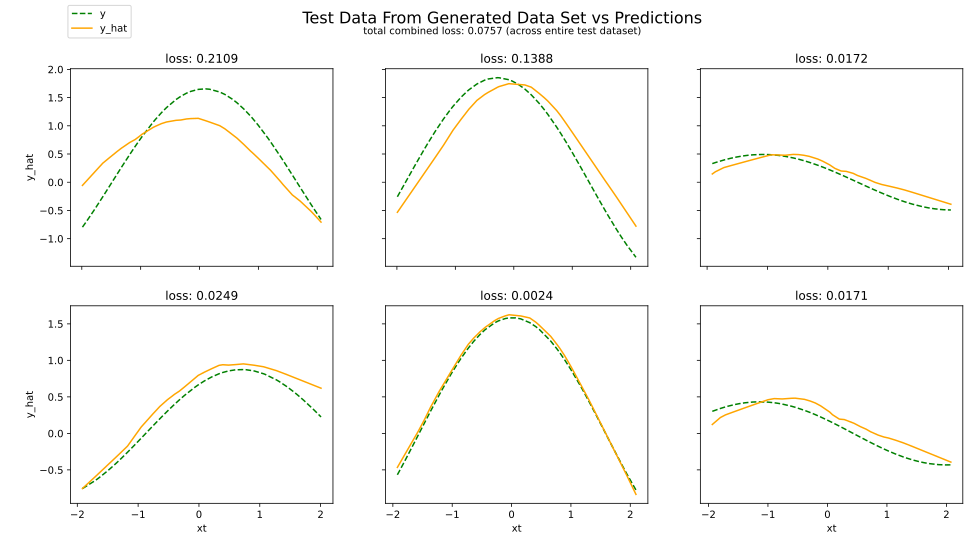

In [397]:
#@title Test Model On Test Data Split { run: "auto" }
#@markdown Number of plots to generate from test data:
num_of_plots = 6 #@param {type:"slider", min:6, max:134, step:3}

results = []

# Sum of training loss, no. of examples  
metric = Accumulator(2)

with torch.no_grad():
  # turn models to eval
  encoder.eval()
  decoder.eval()

  for xt, yt in test_iter:

    # combine x and y
    xt_yt = torch.cat((xt, yt), dim=2) 

    # take only a random Nc number of x_y points (subset) to get xc and yc
    Nc = random.randint(1, Npts)
    rand_columns = torch.randperm(Npts)[:Nc]
    xc_yc = xt_yt[:, rand_columns]

    r_c = encoder(xc_yc)
    r_C = r_c.view(r_c.size(0), -1).mean(1).view(-1, 1, 1)
    rc_xt = torch.cat((r_C.expand_as(xt), xt), dim=2)

    y_hat = decoder(rc_xt)

    test_lost = loss(y_hat, yt).item()

    results.append((xt.squeeze().detach().numpy(), 
                      yt.squeeze().detach().numpy(),
                      y_hat.squeeze().detach().numpy(),
                      test_lost
                    ))
    
    metric.add(test_lost, 1)

combined_loss = metric[0] / metric[1]

result_iterator = iter(results)

cols = 3
rows = math.ceil(num_of_plots/cols)

fig, ax = plt.subplots(rows, cols, sharey='row', figsize=(16, 4 * rows))

fig.suptitle('Test Data From Generated Data Set vs Predictions', fontsize=16)
fig.text(0.5, 0.94,"total combined loss: {} (across entire test dataset)".format(
    round(combined_loss, 4)), ha="center")

for i in range(rows):
  for j in range(cols):
    x, y, y_hat, test_loss = next(result_iterator)
    ax[i,j].plot(x, y, "--", color="green",label="y")
    ax[i,j].plot(x, y_hat, "-", color="orange", label="y_hat")
    ax[i,j].title.set_text("loss: {}".format(round(test_loss,4)))
    ax[i,j].set(xlabel='xt', ylabel='y_hat')
    ax[i,j].label_outer()
    
    if i == 1 and j == 2:
      handles, labels = ax[i,j].get_legend_handles_labels()
      fig.legend(handles, labels, loc=(0.07, 0.93))


# Test data  

* Test data are stored in a dictionary where each key has the data for a single function $f_a$. We have generated 6 different functions named as `function_num_1`, `function_num_2` and so on. 

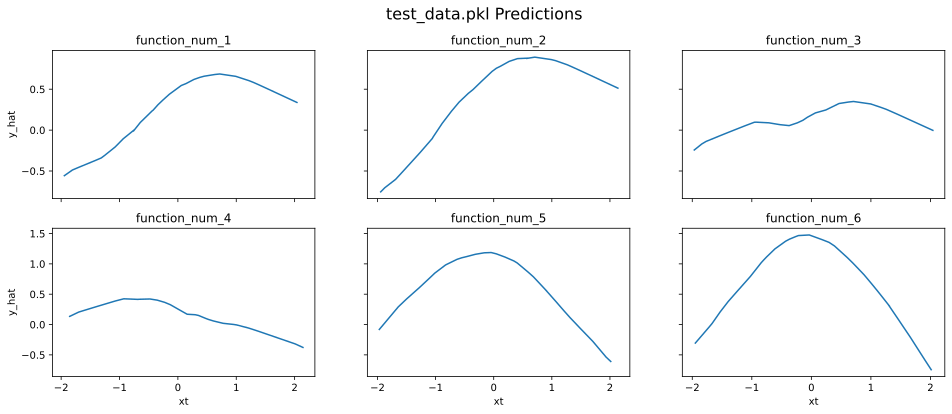

In [398]:
import pickle
path_to_the_pickle = '/content/gdrive/MyDrive/Colab Notebooks/test_data.pkl'
test_data = pickle.load(open(path_to_the_pickle,'rb'))

results = []

for i in range(1,7):
  name = 'function_num_{}'.format(i)
  x_c = test_data[name]['context_pairs'][0]
  y_c = test_data[name]['context_pairs'][1]
  x_t = test_data[name]['x']

  # from training loop
  xc_yc = torch.cat((x_c, y_c), dim=2)
  r_c = encoder(xc_yc)
  r_C = r_c.view(r_c.size(0), -1).mean(1).view(-1, 1, 1)
  rc_xt = torch.cat((r_C.expand_as(x_t), x_t), dim=2)
  y_hat = decoder(rc_xt)

  results.append((name, x_t.squeeze().detach().numpy(), y_hat.squeeze().detach().numpy()))

result_iterator = iter(results)

# plot each test function
fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(16, 6))
fig.suptitle('test_data.pkl Predictions', fontsize=16)

for i in range(2):
  for j in range(3):
    name, x, y = next(result_iterator)
    ax[i,j].plot(x, y)
    ax[i,j].title.set_text(name)
    ax[i,j].set(xlabel='xt', ylabel='y_hat')
    ax[i,j].label_outer()